# Scaling early and late

## Initialize data

In [118]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf
import nengo_dl
import copy

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [119]:
# obtain images
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

# normalize data by color channel
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

train_images_R = normalize(train_images.transpose()[0].transpose())
train_images_G = normalize(train_images.transpose()[1].transpose())
train_images_B = normalize(train_images.transpose()[2].transpose())
test_images_R = normalize(test_images.transpose()[0].transpose())
test_images_G = normalize(test_images.transpose()[1].transpose())
test_images_B = normalize(test_images.transpose()[2].transpose())

train_images = np.array([train_images_R, train_images_G, train_images_B])
test_images = np.array([test_images_R, test_images_G, test_images_B])

train_images = np.moveaxis(train_images, 0, -1)
test_images = np.moveaxis(test_images, 0, -1)

# verify normalization
print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))
print('test mean:', np.mean(train_images))
print('test stdv:', np.std(train_images))
print('train mean:', np.mean(test_images))
print('train stdv:', np.std(test_images))

((50000, 32, 32, 3), (50000, 1)) ((10000, 32, 32, 3), (10000, 1))
test mean: 5.4830214442821065e-17
test stdv: 1.0000000000000002
train mean: 8.14903700074865e-18
train stdv: 1.0000000000000002


In [120]:
# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))

((50000, 1, 3072), (50000, 1, 1)) ((10000, 1, 3072), (10000, 1, 1))


## Build convolutional network and convert to nengo-dl

Choose one of the following models to obtain the same results

In [4]:
inp = tf.keras.Input(shape=(32, 32, 3))

flatten = tf.keras.layers.Flatten()(inp)

dense0 = tf.keras.layers.Dense(units=3000, activation=tf.nn.relu)(flatten)
dense1 = tf.keras.layers.Dense(units=1500, activation=tf.nn.relu)(dense0)
dense2 = tf.keras.layers.Dense(units=750, activation=tf.nn.relu)(dense1)
dense3 = tf.keras.layers.Dense(units=375, activation=tf.nn.relu)(dense2)
dense4 = tf.keras.layers.Dense(units=188, activation=tf.nn.relu)(dense3)

out = tf.keras.layers.Dense(units=10)(dense4)

model = tf.keras.Model(inputs=inp, outputs=out)

In [121]:
inp = tf.keras.Input(shape=(32, 32, 3))

conv0 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inp)
pool0 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv0)

conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(pool0)
pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(pool1)
pool2 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv2)

flatten = tf.keras.layers.Flatten()(pool2)

dense0 = tf.keras.layers.Dense(units=300, activation=tf.nn.relu)(flatten)
out = tf.keras.layers.Dense(units=10, name='out')(dense0)

model = tf.keras.Model(inputs=inp, outputs=out)

In [122]:
converter = nengo_dl.Converter(model)

## Train the non-spiking network

In [9]:
with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.Adam(0.001),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.sparse_categorical_accuracy]
    )

    sim.fit(
        {converter.inputs[inp]: train_images},
        {converter.outputs[out]: train_labels},
        validation_data=({converter.inputs[inp]: test_images}, {converter.outputs[out]: test_labels}),
        epochs=20
    )

    # save the parameters
    sim.save_params("./5_dense_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/20
250/250 [==============================] - 13s 37ms/step - loss: 1.9963 - probe_loss: 1.9963 - probe_sparse_categorical_accuracy: 0.3183 - val_loss: 1.5610 - val_probe_loss: 1.5610 - val_probe_sparse_categorical_accuracy: 0.4454
Epoch 2/20
250/250 [==============================] - 8s 33ms/step - loss: 1.4911 - probe_loss: 1.4911 - probe_sparse_categorical_accuracy: 0.4729 - val_loss: 1.4304 - val_probe_loss: 1.4304 - val_probe_sparse_categorical_accuracy: 0.4977
Epoch 3/20
250/250 [==============================] - 9s 34ms/step - loss: 1.3702 - probe_loss: 1.3702 - probe_sparse_categorical_accuracy: 0.5150 - val_loss: 1.3961 - val_probe_loss: 1.3961 - val_probe_sparse_categorical_accuracy: 0.5111
Epoch 4/20
250/250 [======================

## Run the non-spiking network

In [233]:
def run_network(
    activation,
    params_file="3_conv_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[out]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons_conv0 = np.linspace(0, np.prod(conv0.shape[1:]), 300, endpoint=False, dtype=np.int32)
    sample_neurons_conv1 = np.linspace(0, np.prod(conv1.shape[1:]), 300, endpoint=False, dtype=np.int32)
    sample_neurons_conv2 = np.linspace(0, np.prod(conv2.shape[1:]), 300, endpoint=False, dtype=np.int32)
    sample_neurons_dense0 = np.linspace(0, np.prod(dense0.shape[1:]), 300, endpoint=False, dtype=np.int32)

    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons_conv0])
        conv1_probe = nengo.Probe(nengo_converter.layers[conv1][sample_neurons_conv1])
        conv2_probe = nengo.Probe(nengo_converter.layers[conv2][sample_neurons_conv2])
        dense0_probe = nengo.Probe(nengo_converter.layers[dense0][sample_neurons_dense0])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=200, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f" test accuracy: {100 * accuracy:.2f}%")

    probe_names = ['conv0', 'conv1', 'conv2', 'dense']
    rates_for_images = []

    for ii in range(10):

        if isinstance(scale_firing_rates, dict):
            scaled_data = np.array([
                data[conv0_probe][ii] * scale_firing_rates[model.layers[1]],
                data[conv1_probe][ii] * scale_firing_rates[model.layers[3]],
                data[conv2_probe][ii] * scale_firing_rates[model.layers[5]],
                data[dense0_probe][ii] * scale_firing_rates[model.layers[8]],
            ])
        else:
            scaled_data = np.array([
                data[conv0_probe][ii] * scale_firing_rates,
                data[conv1_probe][ii] * scale_firing_rates,
                data[conv2_probe][ii] * scale_firing_rates,
                data[dense0_probe][ii] * scale_firing_rates,
            ])

        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.array([np.sum(d, axis=0) / (n_steps * nengo_sim.dt) for d in scaled_data])
        else:
            rates = scaled_data

        rates_for_images.append(rates)
        # for l in range(len(probe_names)):
        #     print("Image #" + str(ii) + ":\n  Layer " + probe_names[l] + ":\n    Mean Firing Rate = " + str(rates[l].mean()) + "\n    Max Firing Rate = " + str(rates[l].max()))

    return (accuracy, np.array(rates_for_images).mean(axis=0))

In [234]:
baseline_accuracy, baseline_rates = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

 test accuracy: 75.50%


## Scale the firing rates for each layer at a time

In [ ]:
synapse = 0.005
base_scale_firing_rates = 50
special_scale_firing_rates = 150
accuracy_and_rates = []

accuracy_and_rates.append(
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=base_scale_firing_rates,
    )
)

scale_firing_rates = {layer:base_scale_firing_rates for layer in model.layers}

for l in [1, 3, 5, 8, 9]:
    scale_firing_rates[model.layers[l]] = special_scale_firing_rates

    print("Scaled layer: " + model.layers[l]._name)
    accuracy_and_rates.append(
        run_network(
            activation=nengo.SpikingRectifiedLinear(),
            n_steps=60,
            synapse=synapse,
            scale_firing_rates=scale_firing_rates,
        )
    )
    scale_firing_rates[model.layers[l]] = base_scale_firing_rates

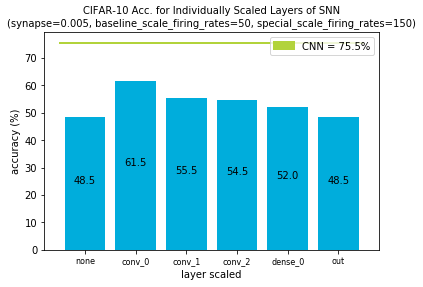

In [236]:
# create graph of accuracy
accuracy_list = np.array([e[0] for e in accuracy_and_rates])
rates_list = np.array([e[1] for e in accuracy_and_rates])

fig, ax = plt.subplots(1,1)
baseline = plt.Rectangle((-0.5,75.5), 6,0, fill=True, color='#B2D33B', linewidth=2, zorder=2)
baseline.set_label('CNN = ' + str(baseline_accuracy * 100) + '%')
ax = ax or plt.gca()
ax.add_patch(baseline)
ax.legend()

def add_labels(y):
    for i in range(len(y)):
        plt.text(i, y[i]*100/2, str(round(y[i]*100,3)), ha='center')

add_labels(accuracy_list)

plt.xlabel("layer scaled")
plt.ylabel("accuracy (%)")
plt.title("CIFAR-10 Acc. for Individually Scaled Layers of SNN\n(synapse=" + str(synapse) + ", baseline_scale_firing_rates=" + str(base_scale_firing_rates) + ", special_scale_firing_rates=" + str(special_scale_firing_rates) + ")", size=10)
# labels = [layer._name for layer in model.layers[2:]]
labels = ['none', 'conv_0', 'conv_1', 'conv_2', 'dense_0', 'out']
plt.bar(labels, accuracy_list*100, color='#00ADDC')
plt.xticks(rotation=0, size=8)
plt.savefig("./scaling_early_and_late_images/3_conv/rates_" + str(synapse)[2:] + "_" + str(base_scale_firing_rates) + "_" + str(special_scale_firing_rates), dpi=300)

In [ ]:
# scale layers in pairs
synapse = 0.005
base_scale_firing_rates = 50
special_scale_firing_rates = 150
accuracy_list = []

accuracy_list.append(
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=base_scale_firing_rates,
    )
)

scale_firing_rates = {layer:base_scale_firing_rates for layer in model.layers}
pairs = [(1,3), (3,5), (5, 8), (8, 9)]

for pair in pairs:

    scale_firing_rates[model.layers[pair[0]]] = special_scale_firing_rates
    scale_firing_rates[model.layers[pair[1]]] = special_scale_firing_rates

    print("Scaled layer: " + model.layers[l]._name)
    accuracy = run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=scale_firing_rates)

    accuracy_list.append(accuracy)

    scale_firing_rates[model.layers[pair[0]]] = base_scale_firing_rates
    scale_firing_rates[model.layers[pair[1]]] = base_scale_firing_rates

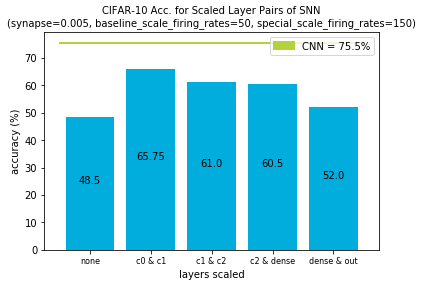

In [167]:
# create graph for scaled layer pairs
fig, ax = plt.subplots(1,1)
baseline = plt.Rectangle((-0.5,75.5), 5,0, fill=True, color='#B2D33B', linewidth=2, zorder=2)
baseline.set_label('CNN = ' + str(baseline_accuracy * 100) + '%')
ax = ax or plt.gca()
ax.add_patch(baseline)
ax.legend()

def addlabels(y):
    for i in range(len(y)):
        plt.text(i, y[i]*100/2, str(round(y[i]*100,3)), ha='center')

addlabels(accuracy_list)

accuracy_list = np.array(accuracy_list)
plt.xlabel("layers scaled")
plt.ylabel("accuracy (%)")
plt.title("CIFAR-10 Acc. for Scaled Layer Pairs of SNN\n(synapse=" + str(synapse) + ", baseline_scale_firing_rates=" + str(base_scale_firing_rates) + ", special_scale_firing_rates=" + str(special_scale_firing_rates) + ")", size=10)
# labels = [layer._name for layer in model.layers[2:]]
labels = ['none', 'c0 & c1', 'c1 & c2', 'c2 & dense', 'dense & out']
plt.bar(labels, accuracy_list*100, color='#00ADDC')
plt.xticks(rotation=0, size=8)
plt.savefig("./scaling_early_and_late_images/3_conv/barred_pairs_" + str(synapse)[2:] + "_" + str(base_scale_firing_rates) + "_" + str(special_scale_firing_rates), dpi=300)